In [1]:
import sys
sys.path.append("../")

In [1]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from fastai.text import LanguageModelLoader, LanguageModelData
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens.pkl")

In [4]:
# Filter out empty texts
tokens = [x for x in tokens if x.shape[0] > 0]

In [5]:
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 1) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 169361694
Unknown Percentage: 0.54 %


In [7]:
bptt = 100
batch_size = 128
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = LanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt)
val_loader = LanguageModelLoader(
    np.concatenate(val_tokens), batch_size, bptt)
tst_loader = LanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt)

In [8]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]):
        if trn_tokens[i][j] == 1:
            tmp.append(trn_tokens[i][j-1])
Counter(tmp).most_common(10)

[(4, 9459),
 (1, 1413),
 (7, 506),
 (3, 403),
 (2, 388),
 (80, 147),
 (21, 131),
 (466, 118),
 (112, 115),
 (79, 114)]

In [9]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]-1):
        if trn_tokens[i][j] == 4:
            tmp.append(trn_tokens[i][j+1])
Counter(tmp).most_common(10)

[(1, 9459),
 (5, 7343),
 (10, 4999),
 (9, 4229),
 (52, 2333),
 (68, 2039),
 (35, 1945),
 (99, 1365),
 (118, 1287),
 (54, 1271)]

In [10]:
mapping = joblib.load("../data/mapping.pkl")

In [11]:
itos = ['<unk>'] *  n_tok
for k, v in mapping.items():
    itos[v] = k

In [12]:
itos[10]

'2'

In [13]:
path = Path("../data/cache/lm/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=0, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_dl=tst_loader
)

### QRNN Model

In [21]:
drops = np.array([0.05, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=4,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=True
)

In [20]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

  1%|          | 73/10598 [00:07<17:33,  9.99it/s, loss=8.27]

KeyboardInterrupt: 

In [22]:
lrs = 2e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      4.565469   4.451593  
    1      4.183575   4.027893                                  
    2      4.071145   3.896606                                  
    3      4.008949   3.823468                                  
    4      3.956882   3.769333                                  
    5      3.918282   3.731168                                  
    6      3.894945   3.702762                                  
    7      3.872636   3.680947                                  
    8      3.854972   3.663175                                  
    9      3.843054   3.652749                                  


[3.6527488382143667]

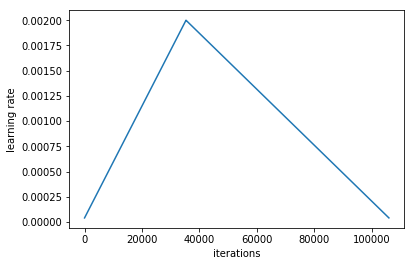

In [23]:
learner.sched.plot_lr()

In [43]:
lrs = 5e-4
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      3.849988   3.651798  
    1      3.843731   3.652289                                  
    2      3.851551   3.653735                                  
    3      3.851972   3.649651                                  
    4      3.841882   3.643531                                  
    5      3.83303    3.639206                                  
 73%|███████▎  | 7710/10598 [12:47<04:47, 10.05it/s, loss=3.81]

KeyboardInterrupt: 

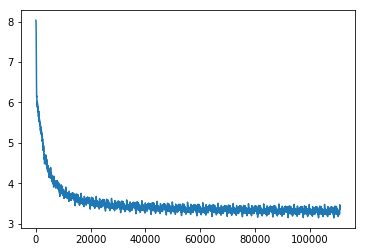

In [14]:
learner.sched.plot_loss()

In [44]:
learner.save("lm_qrnn")
learner.save_encoder("lm_qrnn_enc")

In [ ]:
learner.load("lm_qrnn")

### LSTM

In [45]:
drops = np.array([0.1, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

 86%|████████▌ | 9069/10584 [13:20<02:13, 11.33it/s, loss=16.3]

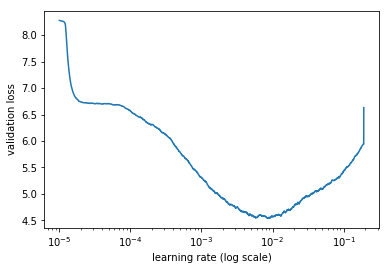

In [10]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [46]:
lrs = 6e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      3.997274   3.874192  
    1      3.886165   3.745574                                  
    2      3.883702   3.74487                                   
    3      3.858762   3.71016                                   
    4      3.807739   3.652625                                  
    5      3.768698   3.608639                                  
    6      3.73006    3.56887                                   
    7      3.699534   3.535021                                  
    8      3.664338   3.502909                                  
    9      3.647414   3.479918                                  


[3.479918434955321]

In [47]:
lrs = 1e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      3.644362   3.477419  
    1      3.648247   3.47944                                   
    2      3.649749   3.482529                                  
    3      3.649635   3.479658                                  
    4      3.642473   3.473618                                  
    5      3.642013   3.466264                                  
    6      3.626558   3.459457                                  
    7      3.62733    3.454232                                  
    8      3.614818   3.449351                                  
    9      3.615465   3.446883                                  


[3.4468825760903012]

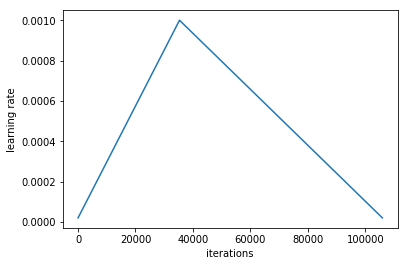

In [48]:
learner.sched.plot_lr()

In [49]:
learner.save("lm_lstm")
learner.save_encoder("lm_lstm_enc")

In [68]:
# Use tons of memory...
# pred, targ = learner.predict_with_targs(is_test=True)

TypeError: 'NoneType' object is not iterable

In [33]:
tmp_iter = iter(trn_loader)

In [65]:
next(tmp_iter)[0].shape

torch.Size([93, 128])

In [66]:
learner.load("lm_lstm")

## Test the model

In [50]:
learner.model.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(3937, 300, padding_idx=0)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(3937, 300, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(300, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 300)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=300, out_features=3937, bias=False)
    (dropout): LockedDropout()
  )
)

### Next Character Inference

In [51]:
tokens = list(map(lambda x: mapping.get(x, 1), "德国是世界大国之一，其国内生产总值以国际汇率计"))
tokens

[170,
 14,
 15,
 149,
 271,
 19,
 14,
 41,
 11,
 2,
 54,
 14,
 134,
 51,
 230,
 207,
 823,
 24,
 14,
 411,
 1255,
 584,
 224]

In [52]:
logits, _, _ = learner.model(T(tokens).unsqueeze(1))
logits.shape

torch.Size([23, 3937])

In [53]:
sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
preds = []
for i in range(1, 4):
      preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
# preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
pd.DataFrame({"orig": [x for x in "德国是世界大国之一，其国内生产总值以国际汇率计 "], 
              "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

,orig,pred_1,pred_2,pred_3
0,德,,,
1,国,国,州,克
2,是,的,人,国
3,世,一,否,最
4,界,界,上,纪
5,大,上,最,第
6,国,学,赛,战
7,之,的,，,家
8,一,一,首,间
9,，,。,，,的


In [54]:
def eval(texts):
    learner.model[0].reset()
    tokens = list(map(lambda x: mapping.get(x, 1), texts))
    logits, _, _ = learner.model(T(tokens).unsqueeze(1))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    return pd.DataFrame({"orig": [x for x in texts + " "], 
                  "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

In [55]:
eval("在现代印刷媒体，卡通是一种通常有幽默色")

,orig,pred_1,pred_2,pred_3
0,在,,,
1,现,1,2,中
2,代,场,代,在
3,印,化,的,国
4,刷,度,刷,第
5,媒,业,厂,品
6,体,体,介,报
7,，,上,中,的
8,卡,以,并,在
9,通,尔,拉,斯


In [56]:
eval("对中国与南洋发动全面的战争。\n1990年代，中")

,orig,pred_1,pred_2,pred_3
0,对,,,
1,中,于,象,外
2,国,国,华,央
3,与,的,大,人
4,南,中,日,印
5,洋,非,美,韩
6,发,的,之,各
7,动,展,生,动
8,全,的,了,战
9,面,面,球,国


### Generate Sentence

In [1]:
import random

def get_tokens(texts):
    return list(map(lambda x: mapping.get(x, 1), texts))

def generate_text(tokens,N=25):    
    preds = []          
    for i in range(N):   
        learner.model[0].reset()          
        logits, _, _ = learner.model(T(tokens).unsqueeze(1))
        probs = F.softmax(logits).data.cpu().numpy()[-1, :]
        candidates = np.argsort(probs)[::-1]
        while True:
            candidate = np.random.choice(candidates, p=probs[candidates])
            if candidate > 1 and ord(itos[candidate]) > 255:
                print(probs[candidates][:3], probs[candidate])
                preds.append(candidate)
                break
        # for candidate in candidates:
        #     if candidate > 1 and ord(itos[candidate]) > 255 and (random.random() < probs[candidate] or probs[candidate] < 0.2):
        #         print(probs[candidate])
        #         preds.append(candidate)
        #         break
        # tokens  = [preds[-1]]# 
        tokens.append(preds[-1])
        # tokens = [:1]
        print("".join([itos[x] for x in tokens])) 
    
generate_text(get_tokens("德国是世界大国之一，其国内生产总值以国际汇率为主，"))

NameError: name 'mapping' is not defined

In [73]:
generate_text(get_tokens("在现代印刷媒体，卡通是一种通常有幽默色"))

[0.97204 0.01741 0.00242] 0.97203964
在现代印刷媒体，卡通是一种通常有幽默色彩
[0.79854 0.04406 0.0319 ] 0.79853874
在现代印刷媒体，卡通是一种通常有幽默色彩的
[0.04831 0.01729 0.01346] 2.5049203e-05
在现代印刷媒体，卡通是一种通常有幽默色彩的彗
[0.92119 0.01683 0.00602] 0.016833587
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体
[0.26568 0.23342 0.01468] 0.23341978
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。
[0.10097 0.05627 0.03845] 0.0023278366
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿
[0.1108  0.09062 0.04832] 0.014364317
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯
[0.09415 0.07406 0.07022] 0.022943802
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯蒂
[0.05765 0.05608 0.05353] 0.0014080367
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯蒂一
[0.14327 0.12997 0.06533] 0.004424166
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯蒂一向
[0.06895 0.0454  0.04008] 0.0005687519
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯蒂一向到
[0.25465 0.11516 0.03191] 0.25464857
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯蒂一向到了
[0.15358 0.07915 0.02014] 0.0040254504
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯蒂一向到了该
[0.07732 0.04548 0.03315] 0.0004444278
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯蒂一向到了该办
[0.73926 0.12025 0.06847] 0.06847328
在现代印刷媒体，卡通是一种通常有幽默色彩的彗体。阿斯蒂一向到了该办法
[0.2709 

In [74]:
generate_text(get_tokens("在现代印刷媒体， 第"))

[0.33281 0.22589 0.11032] 0.22588727
在现代印刷媒体， 第二
[0.15895 0.10703 0.04518] 0.15895009
在现代印刷媒体， 第二次
[0.68488 0.01888 0.01076] 0.6848839
在现代印刷媒体， 第二次世
[0.99992 0.00004 0.00001] 0.9999187
在现代印刷媒体， 第二次世界
[0.99946 0.00005 0.00005] 0.9994642
在现代印刷媒体， 第二次世界大
[0.99994 0.00001 0.00001] 0.9999356
在现代印刷媒体， 第二次世界大战
[0.17927 0.14888 0.09744] 0.17927426
在现代印刷媒体， 第二次世界大战期
[0.99924 0.00016 0.00005] 0.99924004
在现代印刷媒体， 第二次世界大战期间
[0.76657 0.01834 0.00865] 0.7665748
在现代印刷媒体， 第二次世界大战期间，
[0.03996 0.02927 0.02716] 0.0015408307
在现代印刷媒体， 第二次世界大战期间，先
[0.42428 0.08643 0.07613] 0.42427954
在现代印刷媒体， 第二次世界大战期间，先后
[0.13964 0.06443 0.04112] 0.13964178
在现代印刷媒体， 第二次世界大战期间，先后在
[0.04719 0.03397 0.02794] 0.0022378713
在现代印刷媒体， 第二次世界大战期间，先后在「
[0.02083 0.01673 0.01662] 0.00266622
在现代印刷媒体， 第二次世界大战期间，先后在「最
[0.17932 0.09813 0.09307] 0.006299039
在现代印刷媒体， 第二次世界大战期间，先后在「最优
[0.60013 0.03076 0.03055] 0.60013026
在现代印刷媒体， 第二次世界大战期间，先后在「最优秀
[0.4149  0.02621 0.01749] 0.4148982
在现代印刷媒体， 第二次世界大战期间，先后在「最优秀的
[0.03133 0.02942 0.01721] 0.0015

In [75]:
generate_text(get_tokens("日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。"))           

[0.10539 0.08652 0.05457] 3.3233395e-05
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜
[0.44787 0.13044 0.13019] 0.44787207
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占
[0.97914 0.01888 0.0003 ] 0.979142
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭
[0.32348 0.07669 0.04778] 0.0044252477
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆
[0.94447 0.02147 0.01202] 0.9444729
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆军
[0.06924 0.06916 0.03364] 0.0036778732
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆军使
[0.88803 0.02943 0.0098 ] 0.0001601568
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆军使事
[0.57382 0.13503 0.06514] 0.573817
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆军使事件
[0.10493 0.05362 0.05189] 0.0066636247
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆军使事件以
[0.03981 0.03943 0.02576] 0.021399217
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆军使事件以及
[0.03158 0.02385 0.02332] 0.0032025902
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆军使事件以及无
[0.11303 0.06241 0.0614 ] 0.0019601176
日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。拜占庭陆军使事件以及无界
[0.23886 0.05353 0.01799] 0.23886451
日本后来成为第二次世

In [76]:
generate_text(get_tokens("传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制"
                         "。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基"
                         "础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与"
                         "战国"))           

[0.65026 0.05711 0.02879] 0.65025944
传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与战国时
[0.54108 0.45224 0.00129] 0.4522431
传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与战国时代
[0.25275 0.2381  0.1895 ] 0.2527525
传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与战国时代，
[0.03927 0.03271 0.03061] 0.0015480097
传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与战国时代，长
[0.48057 0.09687 0.05162] 0.01976907
传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治

In [77]:
generate_text(get_tokens("特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富"))

[0.10299 0.0882  0.0566 ] 0.0009332779
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价
[0.64191 0.31716 0.01799] 0.31716254
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值
[0.12555 0.08338 0.05092] 0.011666127
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大
[0.22541 0.09939 0.0516 ] 0.050168876
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于
[0.05374 0.0517  0.02946] 0.0033325765
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于现
[0.39742 0.14112 0.09683] 0.051533077
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于现时
[0.24899 0.24309 0.02744] 0.24898584
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于现时，
[0.02887 0.0253  0.01916] 0.014872824
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于现时，在
[0.03054 0.02871 0.02804] 0.023710221
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于现时，在国
[0.29887 0.26461 0.17246] 0.29886985
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于现时，在国内
[0.14261 0.05351 0.03881] 0.00056786457
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于现时，在国内申
[0.87107 0.07117 0.01499] 0.8710653
特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富价值大于现时，在国内申请
[0.08653 0.

In [78]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地"))

[0.60864 0.07306 0.05637] 0.0563702
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区
[0.55778 0.27253 0.04076] 0.0011583116
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以
[0.53452 0.13243 0.11574] 0.5345151
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及
[0.02874 0.02578 0.02051] 0.0028437753
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民
[0.50225 0.15766 0.07535] 0.50225496
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民间
[0.13714 0.06068 0.01626] 0.001399822
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民间热
[0.18219 0.15026 0.09835] 0.041872736
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民间热心
[0.36656 0.0677  0.04467] 0.044669893
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民间热心人
[0.4277  0.34991 0.04604] 0.34990644
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民间热心人物
[0.32108 0.28932 0.15541] 0.32107615
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民间热心人物的
[0.04225 0.03284 0.01978] 0.019776525
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民间热心人物的活
[0.96619 0.02029 0.00404] 0.9661872
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地区以及民间热心人物的活动
[0.54153 0.25039 

In [79]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，"
                         "呈现出一个与天际线中的香港不同的景象"))

[0.56026 0.30826 0.01554] 0.56026465
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。
[0.19394 0.04387 0.0378 ] 0.0015059201
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作
[0.82864 0.09443 0.02558] 0.82864255
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作为
[0.15802 0.04953 0.02116] 0.003574114
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作为西
[0.22203 0.10498 0.0479 ] 0.011606572
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作为西部
[0.13052 0.08852 0.02701] 0.13051753
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作为西部地
[0.90432 0.04592 0.00598] 0.90431553
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作为西部地区
[0.41698 0.05347 0.03663] 0.0009295838
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作为西部地区部
[0.61618 0.21744 0.14397] 0.61617976
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作为西部地区部分
[0.1628  0.14807 0.04037] 0.14806625
香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，呈现出一个与天际线中的香港不同的景象。作为西部地区部分地

In [65]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Insta"))

1.7492926e-05
香港有半数人住在公屋，如今这里意外成为Insta组
0.35289606
香港有半数人住在公屋，如今这里意外成为Insta组织
0.37017646
香港有半数人住在公屋，如今这里意外成为Insta组织的
0.0905959
香港有半数人住在公屋，如今这里意外成为Insta组织的一
0.5507382
香港有半数人住在公屋，如今这里意外成为Insta组织的一部
0.7318875
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分
0.32186127
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，
0.051492844
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而
0.15504123
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且
0.0629118
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在
0.02319025
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香
0.99780566
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港
0.11965721
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的
0.02037998
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的地
0.3514001
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的地区
0.14796719
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的地区，
0.04125365
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的地区，有
0.11210539
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的地区，有些
0.11153627
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的地区，有些人
0.08680985
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的地区，有些人认
0.9763025
香港有半数人住在公屋，如今这里意外成为Insta组织的一部分，而且在香港的地区，有些人认为
0.10648458
香港有半